In [1]:
import os
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import scvi
import scanpy as sc
import squidpy as sq
import tangram as tg
import cellcharter as cc
import matplotlib.pyplot as plt
import matplotlib.colors as col

Global seed set to 0


In [2]:
#Set working directory
os.chdir("../")

In [3]:
adata_list = []

for sample in ['TXP_O5-WT','TXP_O11-PRO','TXP_O8-MES-1']:
    adata = sc.read_10x_h5(filename=f'XeniumData/{sample}/cell_feature_matrix.h5')
    df = pd.read_csv(f'XeniumData/{sample}/cells.csv.gz', compression='gzip')
    
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()

    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

    adata.obs['sample'] = sample
    adata_list.append(adata)

In [4]:
adata = ad.concat(adata_list, axis=0, merge='same', pairwise=True, index_unique='_')
adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
adata.obs['condition'] = adata.obs['sample'].astype('category')

In [5]:
sc.pp.filter_cells(adata, min_counts=1)

In [6]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

Negative DNA probe count % : 0.4647971177216947
Negative decoding count % : 0.0033989695497209102


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

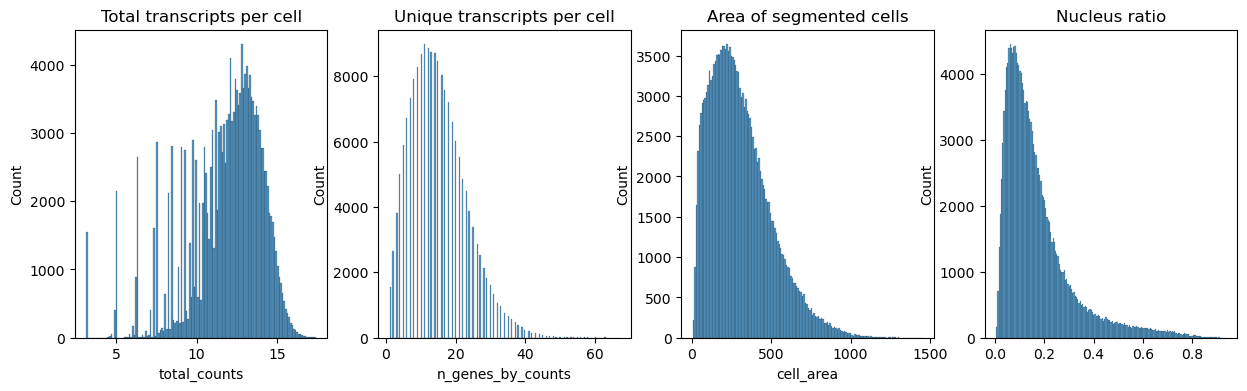

In [7]:
# Visualize QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)

print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"],kde=False,ax=axs[0],)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"],kde=False,ax=axs[1],)

axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"],kde=False,ax=axs[2],)

axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"],kde=False,ax=axs[3],)

In [8]:
# Dimensional Reduction
scvi.settings.seed = 1234
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key='sample')

model = scvi.model.SCVI(adata)
#model.train(early_stopping=True, enable_progress_bar=True)
#model.save("GBMOrganoid/Checkpoints/scvi_model/txp", overwrite=True)
model = model.load("GBMOrganoid/Checkpoints/scvi_model/txp", adata)

adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

Global seed set to 1234


INFO     File GBMOrganoid/Checkpoints/scvi_model/txp/model.pt already downloaded                                   


In [9]:
# Spatial Clustering
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
cc.gr.remove_long_links(adata)

cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
autok = cc.tl.ClusterAutoK.load("GBMOrganoid/Checkpoints/ClusterAutoK/txp")

#autok = cc.tl.ClusterAutoK(n_clusters=(2,20), max_runs=10, model_params=dict(random_state=1234, trainer_params=dict(accelerator='gpu', devices=1)))
#autok.fit(adata, use_rep='X_cellcharter')
#autok.save("GBMOrganoid/Checkpoints/ClusterAutoK/txp")

Iteration 1/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/21 [00:00<?, ?it/s]

Convergence with a change in stability of 0.009652527333249068 reached after 7 iterations


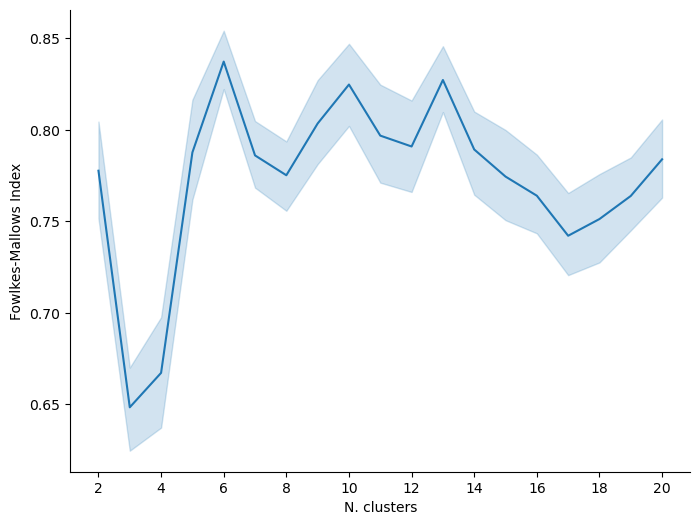

In [12]:
plt.figure(figsize=(8,6))
cc.pl.autok_stability(autok)
plt.xticks(np.arange(autok.n_clusters[1], autok.n_clusters[-1], 2))
plt.ylabel('Fowlkes-Mallows Index')
plt.show()

In [13]:
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')

In [14]:
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}

In [15]:
# Save
adata.write_h5ad('GBMOrganoid/Checkpoints/xenium_txps.h5ad')

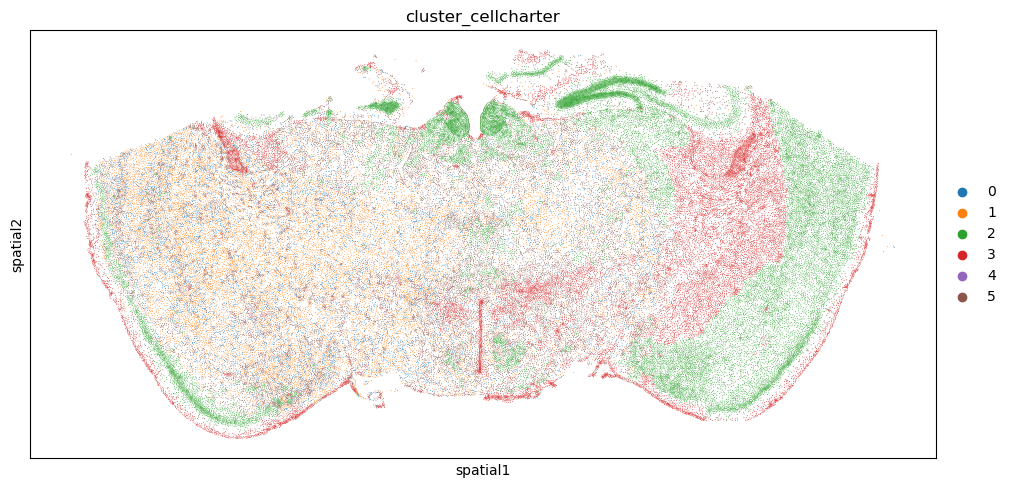

In [16]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    #palette=my_colors2,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['TXP_O5-WT'],
    frameon=True,title=None,
)

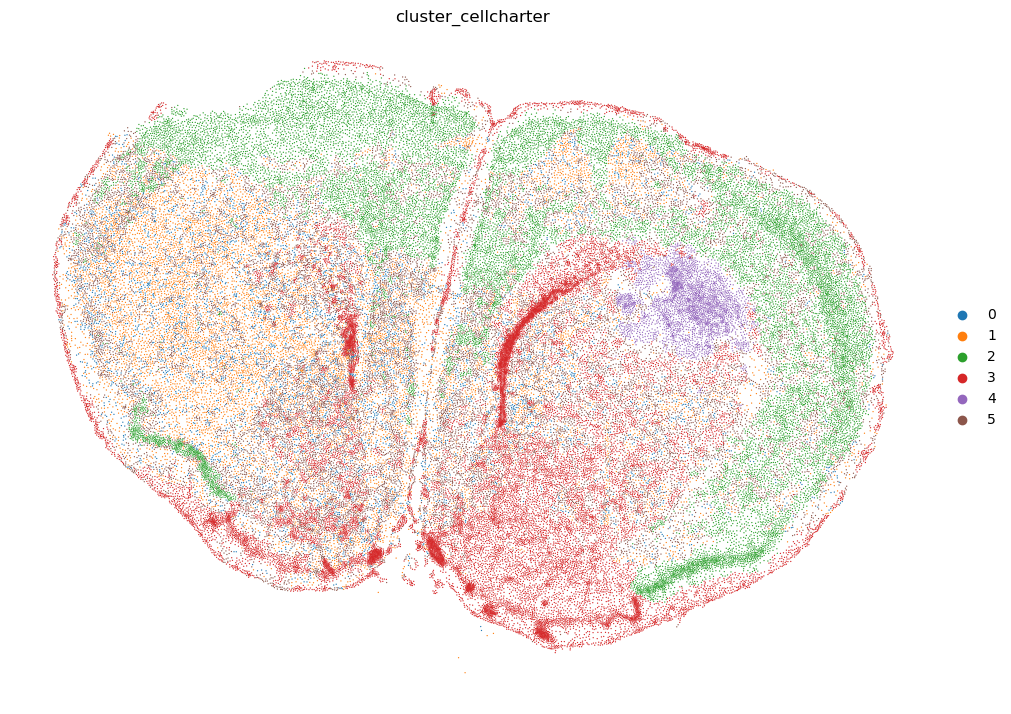

In [17]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    #palette=my_colors2,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['TXP_O11-PRO'],
    frameon=False,title=None,
)

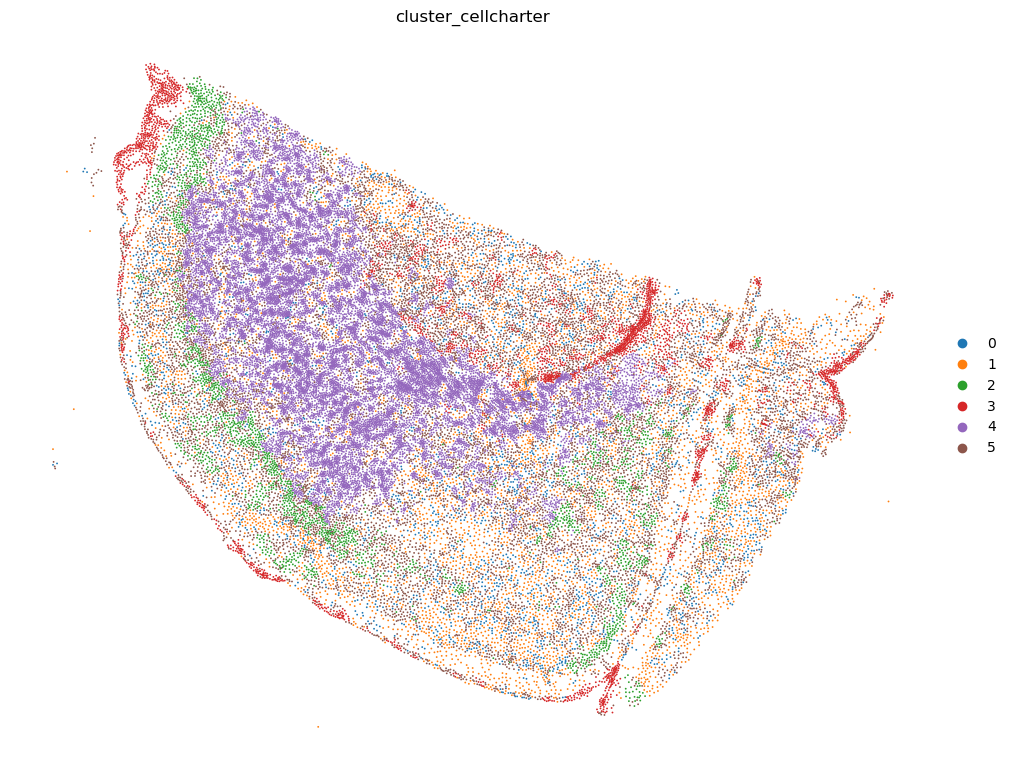

In [18]:
sq.pl.spatial_scatter(
    adata, 
    color=['cluster_cellcharter'], 
    library_key='sample',  
    size=5, 
    img=None,
    spatial_key='spatial',
    #palette=col,
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(10,10),
    ncols=1,
    #library_id=adata.obs['sample'].unique(),
    library_id=['TXP_O8-MES-1'],
    frameon=False,title=None,
)

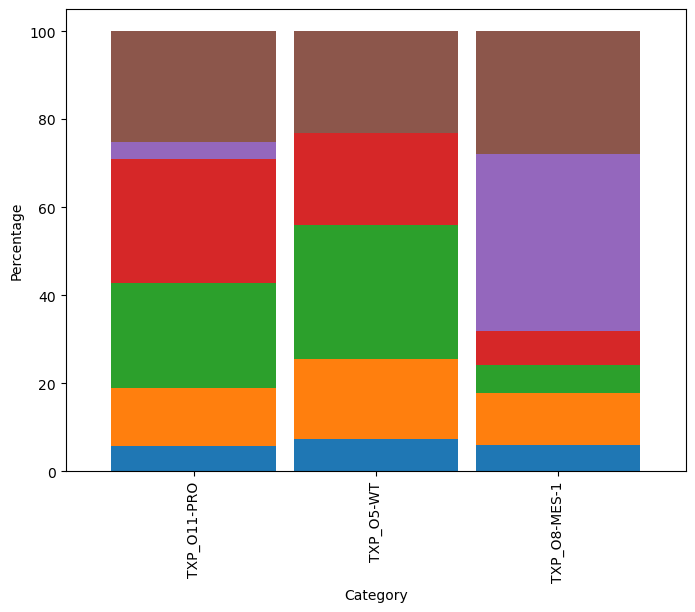

In [19]:
cross_tab = pd.crosstab(adata.obs['sample'],adata.obs['cluster_cellcharter'], normalize='index')*100
ax = cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.9)
ax.get_legend().remove()
# Add labels to the bars
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
# Set labels and title
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.rcParams['figure.figsize'] = [10, 10]

## Compute Moran's I score

In [ ]:
adata_wt = adata[adata.obs['condition'] == 'TXP_O5-WT']
sq.gr.spatial_neighbors(adata_wt, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_wt,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_wt,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_wt.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_WTtxp.csv')
adata_wt.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_WTtxp.csv')

adata_wt.obs['cluster_cellcharter'].to_csv("GBMOrganoid/CCspatialclusters_WTtxp.csv")

In [ ]:
adata_pro = adata[adata.obs['condition'] == 'TXP_O11-PRO']
sq.gr.spatial_neighbors(adata_pro, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_pro,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_pro,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_pro.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_PROtxp.csv')
adata_pro.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_PROtxp.csv')

adata_pro.obs['cluster_cellcharter'].to_csv("GBMOrganoid/CCspatialclusters_PROtxp.csv")

In [ ]:
adata_mes = adata[adata.obs['condition'] == 'TXP_O8-MES-1']
sq.gr.spatial_neighbors(adata_mes, coord_type="generic", delaunay=True)

sq.gr.spatial_autocorr(
    adata_mes,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

sq.gr.spatial_autocorr(
    adata_mes,
    mode="geary",
    n_perms=100,
    n_jobs=1,
)

adata_mes.uns["moranI"].to_csv('GBMOrganoid/GeneLists/moranI_MEStxp.csv')
adata_mes.uns["gearyC"].to_csv('GBMOrganoid/GeneLists/gearyC_MEStxp.csv')

adata_mes.obs['cluster_cellcharter'].to_csv("GBMOrganoid/CCspatialclusters_MEStxp.csv")